# Procrastination Prediction using OULAD Dataset
**Author:** Jeremiah Agbaje  
**Date:** February 2026

Pre-training a Bi-LSTM model on OULAD behavioral data for transfer learning.

## Setup and Imports

In [1]:
# Install missing  libraries for data manipulation, visualization and training
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow statsmodels -q

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# import sklearn tools
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA

In [4]:
# import tensorflow tools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(f"TensorFlow: {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")

TensorFlow: 2.19.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Load Data from Google Drive

In [6]:
# mount google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# path to data
BASE_PATH = '/content/drive/MyDrive/ALU Capstone/OULAD_data/'

In [8]:
# load datasets from OULAD csv's
print("Loading datasets...")
student_vle = pd.read_csv(BASE_PATH + 'studentVle.csv') # vle = Virtual learning environment
student_assessment = pd.read_csv(BASE_PATH + 'studentAssessment.csv')
student_info = pd.read_csv(BASE_PATH + 'studentInfo.csv')
assessments = pd.read_csv(BASE_PATH + 'assessments.csv')
vle = pd.read_csv(BASE_PATH + 'vle.csv')

print(f"VLE interactions: {len(student_vle):,}") # number of interactions with the vle from sampled students
print(f"Assessments: {len(student_assessment):,}")
print(f"Students: {len(student_info):,}")

Loading datasets...
VLE interactions: 10,655,280
Assessments: 173,912
Students: 32,593


## Data Exploration

1. **studentVle.csv** (10+ million rows)
What it contains: Every single click/interaction students made with the Virtual Learning Environment (VLE)
Columns:

code_module - Course identifier (e.g., AAA, BBB),
code_presentation - Semester (e.g., 2013J for 2013 January),
id_student - Unique student ID,
id_site - Specific VLE resource (video, quiz, forum),
date - Day number relative to course start,
sum_click - Number of clicks on that resource that day,

Used for: Creating behavioral features (login patterns, study regularity, cramming behavior)

In [9]:

student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


2. **studentAssessment.csv** (~173k rows)
What it contains: Student submissions for assignments/exams
Columns:

id_assessment - Assignment ID,
id_student - Student ID,
date_submitted - When they submitted (day number),
is_banked - Whether they used previous credit,
score - Grade received,  

Used for: Late submission detection, procrastination patterns

In [10]:
student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


4. **studentInfo.csv**(~32k rows)
What it contains: Demographics and outcomes
Columns:

id_student - Student ID
code_module, code_presentation - Course/semester
gender, region, highest_education, age_band
num_of_prev_attempts - Retaking course?
studied_credits - Workload
disability
final_result - Pass/Fail/Withdrawn/Distinction

Used for: Identifying unique students, sampling, potentially demographic analysis (not used in your current notebook)

In [11]:
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


3. **assessments.csv**(~206 rows)
What it contains: Information about each assignment
Columns:

id_assessment - Assignment ID
code_module - Course
code_presentation - Semester
assessment_type - TMA (homework), CMA (quiz), Exam
date - Official deadline (key for detecting late work!)
weight - % of final grade

Used for: Calculating how late submissions were by comparing studentAssessment.date_submitted vs assessments.date

In [12]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [13]:
# check for missing values in the student_vle and student_assessment datasets
print("Missing values:")
print(student_vle.isnull().sum())
print("\n", student_assessment.isnull().sum())

Missing values:
code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64

 id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64


## Sample Data for Faster Processing

In [14]:
# Reduce sample size to 5000 to show proof of concept remove during full training
SAMPLE_SIZE = 5000
student_sample = student_info.sample(n=min(SAMPLE_SIZE, len(student_info)), random_state=42)
student_ids = student_sample['id_student'].unique()

vle_sample = student_vle[student_vle['id_student'].isin(student_ids)]
assess_sample = student_assessment[student_assessment['id_student'].isin(student_ids)]

print(f"Sampled {len(student_sample)} students")

Sampled 5000 students


## Feature Engineering

Creating behavioral indicators for procrastination

In [15]:
# create features to predict procrastination from OULAD
import numpy as np
import pandas as pd

def engineer_features(vle_data, assess_data, assess_info, student_data):
    features = []

    # ensure one unique row per student per course
    unique_students = student_data[
        ['code_module', 'code_presentation', 'id_student']
    ].drop_duplicates()

    for idx, (module, presentation, sid) in enumerate(unique_students.values):
        if idx % 1000 == 0:
            print(f"Processing {idx}/{len(unique_students)}...")


        # VLE activity for this student in this course

        s_vle = vle_data[
            (vle_data['code_module'] == module) &
            (vle_data['code_presentation'] == presentation) &
            (vle_data['id_student'] == sid)
        ]


        # Assessment behavior (student-level)

        s_assess = assess_data[
            assess_data['id_student'] == sid
        ]

        # attach assessment deadlines
        s_assess_full = s_assess.merge(
            assess_info[['id_assessment', 'date']],
            on='id_assessment',
            how='left'
        )

        if len(s_assess_full) > 0:
            # positive value = submitted late
            s_assess_full['days_late'] = (
                s_assess_full['date_submitted'] - s_assess_full['date']
            )

            late_rate = (s_assess_full['days_late'] > 0).mean()
            avg_late = s_assess_full['days_late'].mean()
        else:
            late_rate = 0
            avg_late = 0


        # VLE engagement patterns

        if len(s_vle) > 0:
            # aggregate clicks per day
            daily = s_vle.groupby('date')['sum_click'].sum()

            # how uneven the study behavior is
            irregularity = daily.std() / daily.mean() if daily.mean() > 0 else 0

            total_clicks = daily.sum()
            active_days = len(daily)

            # gaps between study days
            dates = np.array(sorted(s_vle['date'].unique()))

            if len(dates) > 1:
                gaps = np.diff(dates)
                avg_gap = gaps.mean()
                max_gap = gaps.max()
            else:
                avg_gap = 0
                max_gap = 0
        else:
            irregularity = 0
            total_clicks = 0
            active_days = 0
            avg_gap = 0
            max_gap = 0


        # Last-minute (deadline-driven) behavior

        last_min_ratio = 0
        if len(s_vle) > 0 and len(s_assess_full) > 0:
            for deadline in s_assess_full['date'].dropna():
                week_clicks = s_vle[
                    (s_vle['date'] >= deadline - 7) &
                    (s_vle['date'] <= deadline)
                ]['sum_click'].sum()

                last_min_ratio += week_clicks

            last_min_ratio = (
                last_min_ratio / total_clicks if total_clicks > 0 else 0
            )


        # collect features

        features.append({
            'id_student': sid,
            'code_module': module,
            'code_presentation': presentation,
            'late_rate': late_rate,
            'avg_days_late': avg_late,
            'irregularity': irregularity,
            'last_min_ratio': last_min_ratio,
            'avg_gap': avg_gap,
            'max_gap': max_gap,
            'total_clicks': total_clicks,
            'active_days': active_days,
            'num_assessments': len(s_assess_full)
        })

    return pd.DataFrame(features)


In [16]:
print("Engineering features...")
features_df = engineer_features(vle_sample, assess_sample, assessments, student_sample)
print(f"Created {len(features_df)} feature vectors")

Engineering features...
Processing 0/5000...
Processing 1000/5000...
Processing 2000/5000...
Processing 3000/5000...
Processing 4000/5000...
Created 5000 feature vectors


In [17]:
features_df.head()

,id_student,code_module,code_presentation,late_rate,avg_days_late,irregularity,last_min_ratio,avg_gap,max_gap,total_clicks,active_days,num_assessments
0,2632165,EEE,2014B,0.000000,-5.75,1.017453,0.121253,2.288288,34,2202,112,4
1,2678580,FFF,2014J,0.000000,0.00,0.874513,0.221902,2.361702,9,347,48,2
2,642122,BBB,2014J,0.000000,-3.40,3.350850,0.040218,9.625000,28,1467,17,5
3,1101190,CCC,2014J,0.666667,2.50,1.236347,0.619898,5.653061,43,784,50,9
4,656579,FFF,2014J,0.000000,-65.25,0.954402,0.167120,2.744681,14,5876,95,12


In [18]:
features_clean = features_df[
    (features_df['num_assessments'] > 0) &
    (features_df['total_clicks'] > 0)
].copy()

print(f"Valid students: {len(features_clean)}")

Valid students: 4049


## Feature Distributions

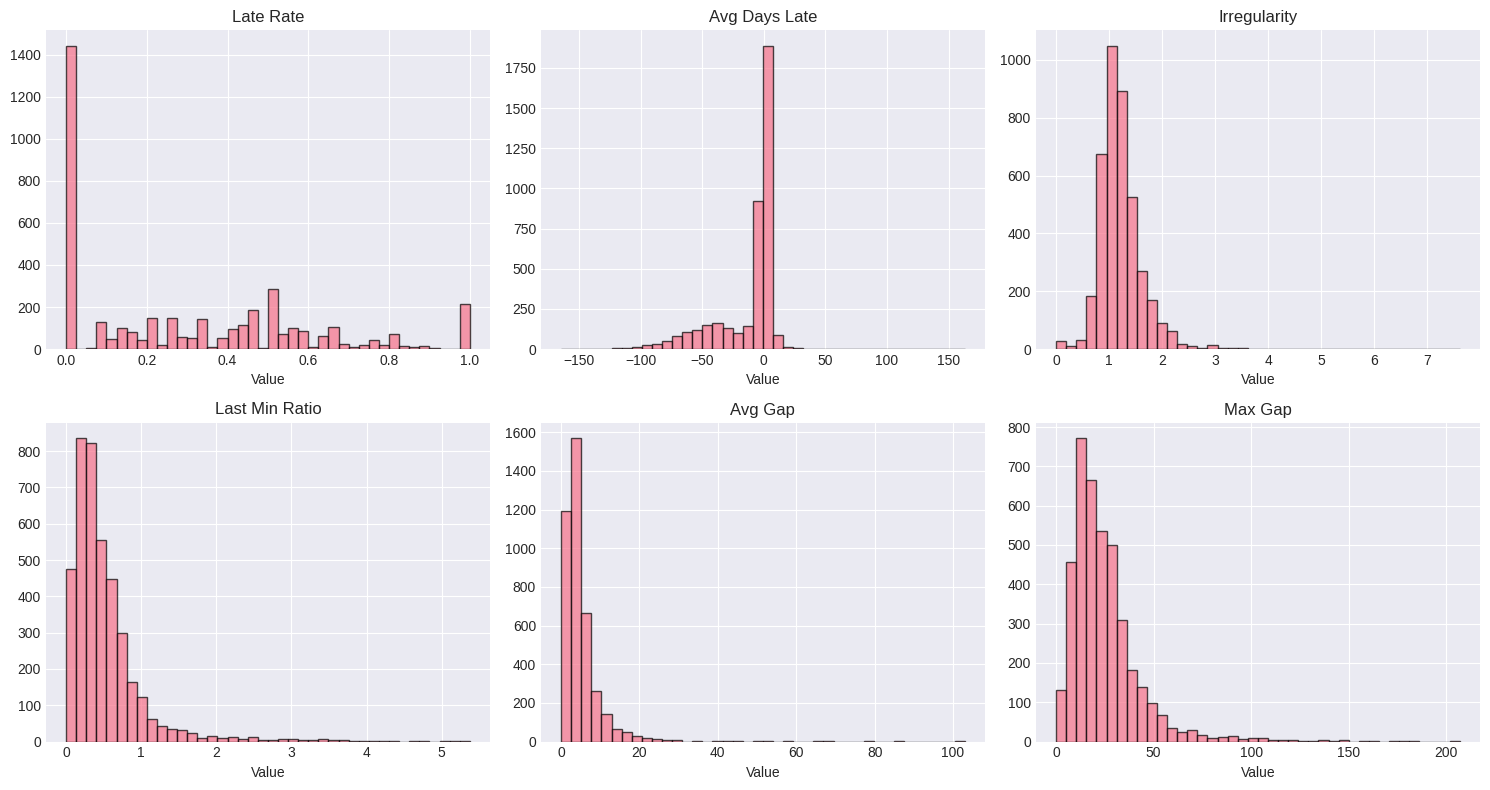

In [19]:
features_to_plot = ['late_rate', 'avg_days_late', 'irregularity', 'last_min_ratio', 'avg_gap', 'max_gap']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, feat in enumerate(features_to_plot):
    axes[idx].hist(features_clean[feat].fillna(0), bins=40, edgecolor='black', alpha=0.7)
    axes[idx].set_title(feat.replace('_', ' ').title())
    axes[idx].set_xlabel('Value')

plt.tight_layout()
plt.show()

In [20]:
features_clean[features_to_plot].describe()

,late_rate,avg_days_late,irregularity,last_min_ratio,avg_gap,max_gap
count,4049.000000,4049.000000,4027.000000,4049.000000,4049.000000,4049.000000
mean,0.297477,-12.401176,1.219647,0.519844,5.142050,25.017288
std,0.299795,25.239052,0.395961,0.530295,5.543369,18.918700
min,0.000000,-164.666667,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-15.777778,0.972050,0.225914,2.384615,13.000000
50%,0.250000,-0.800000,1.154930,0.381963,3.637681,20.000000
75%,0.500000,1.363636,1.382956,0.637540,5.952381,31.000000
max,1.000000,163.222222,7.616745,5.375000,103.000000,207.000000


## Correlation Analysis

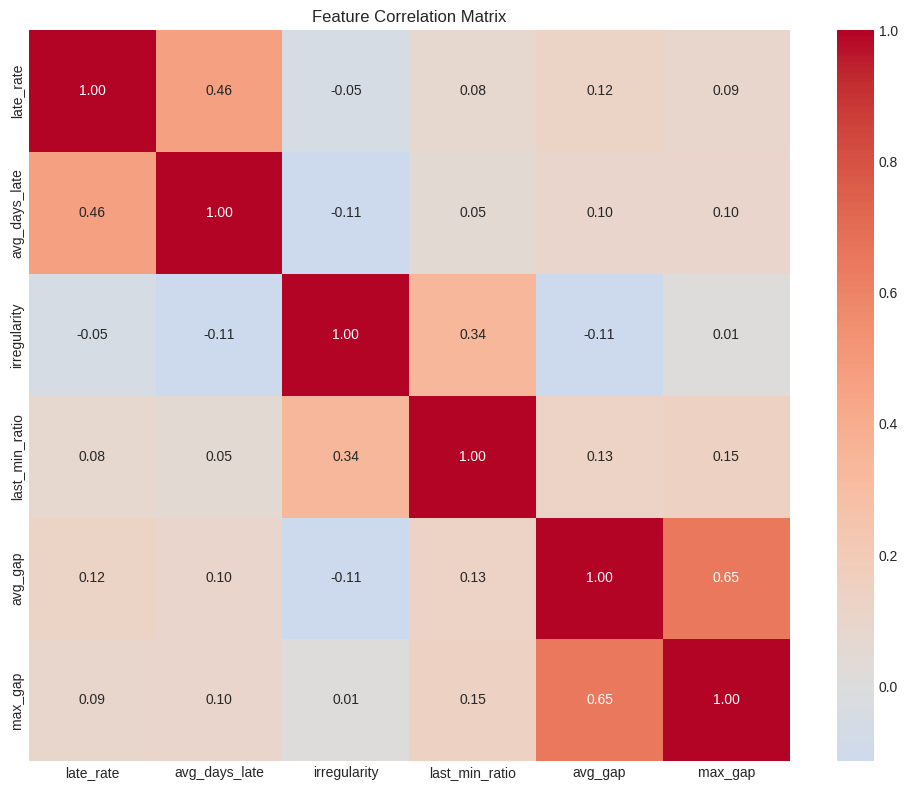

In [21]:
corr_matrix = features_clean[features_to_plot].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## K-Means Clustering

Creating procrastination labels from behavioral patterns

In [22]:
cluster_features = ['late_rate', 'irregularity', 'last_min_ratio', 'avg_gap']
X_cluster = features_clean[cluster_features].fillna(0)

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [24]:
inertias = []
silhouettes = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

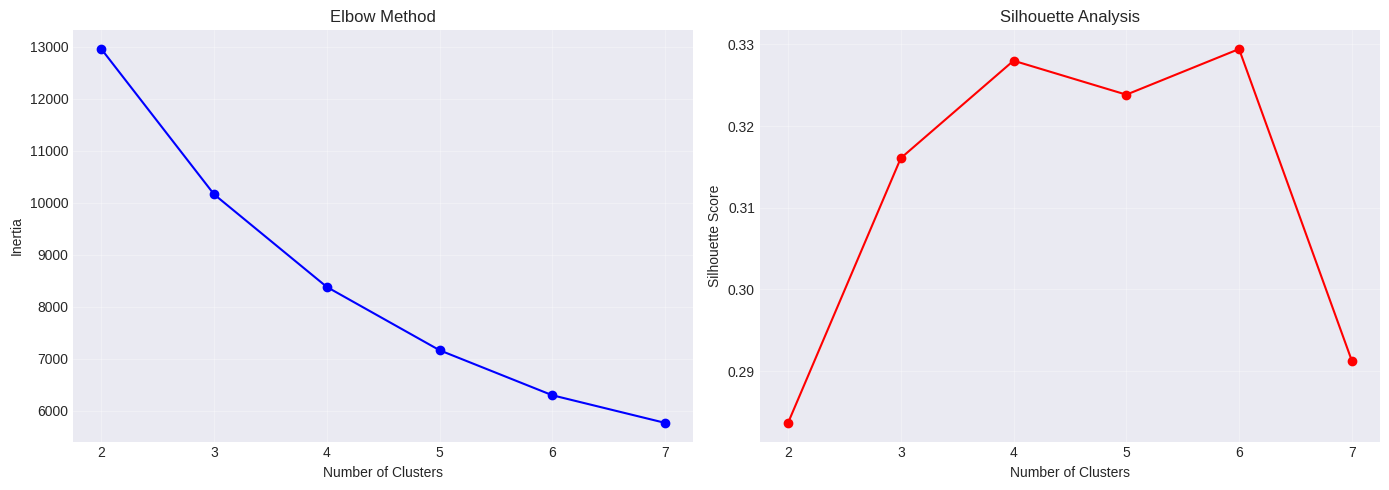

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

ax2.plot(K_range, silhouettes, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [26]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
features_clean['cluster'] = kmeans.fit_predict(X_scaled)

print(features_clean['cluster'].value_counts().sort_index())

cluster
0    1625
1     217
2    2207
Name: count, dtype: int64


In [27]:
cluster_summary = features_clean.groupby('cluster')[cluster_features].mean()
cluster_summary

,late_rate,irregularity,last_min_ratio,avg_gap
cluster,,,,
0,0.600302,1.126881,0.516262,6.347728
1,0.263377,1.978127,2.125631,5.992320
2,0.077862,1.212917,0.364596,4.170715


In [28]:
risk_scores = cluster_summary[['late_rate', 'irregularity', 'last_min_ratio']].mean(axis=1)
cluster_order = risk_scores.sort_values().index.tolist()

risk_map = {cluster_order[0]: 'Low', cluster_order[1]: 'Medium', cluster_order[2]: 'High'}
features_clean['risk'] = features_clean['cluster'].map(risk_map)

print(features_clean['risk'].value_counts())

risk
Low       2207
Medium    1625
High       217
Name: count, dtype: int64


## Cluster Visualization

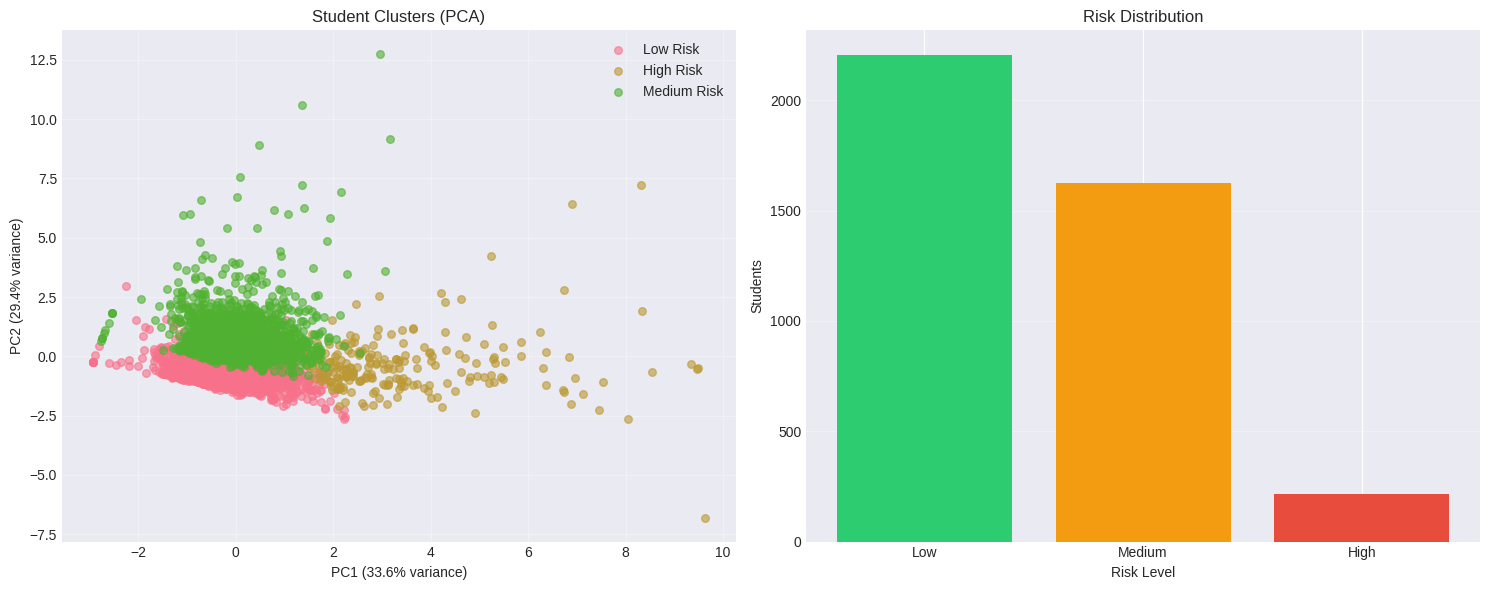

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for cluster in features_clean['cluster'].unique():
    mask = features_clean['cluster'] == cluster
    risk = risk_map[cluster]
    ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'{risk} Risk', alpha=0.6, s=30)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('Student Clusters (PCA)')
ax1.legend()
ax1.grid(True, alpha=0.3)

risk_counts = features_clean['risk'].value_counts()
colors = {'Low': '#2ecc71', 'Medium': '#f39c12', 'High': '#e74c3c'}
ax2.bar(risk_counts.index, risk_counts.values, color=[colors[x] for x in risk_counts.index])
ax2.set_xlabel('Risk Level')
ax2.set_ylabel('Students')
ax2.set_title('Risk Distribution')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Time Series Analysis

Checking if LSTM is appropriate for this sequential data

In [30]:
sample_student = features_clean.iloc[0]
student_clicks = vle_sample[
    (vle_sample['id_student'] == sample_student['id_student']) &
    (vle_sample['code_module'] == sample_student['code_module']) &
    (vle_sample['code_presentation'] == sample_student['code_presentation'])
]

daily_clicks = student_clicks.groupby('date')['sum_click'].sum().sort_index()

print(f"Analyzing student {sample_student['id_student']}")
print(f"Days of activity: {len(daily_clicks)}")

Analyzing student 2632165
Days of activity: 112


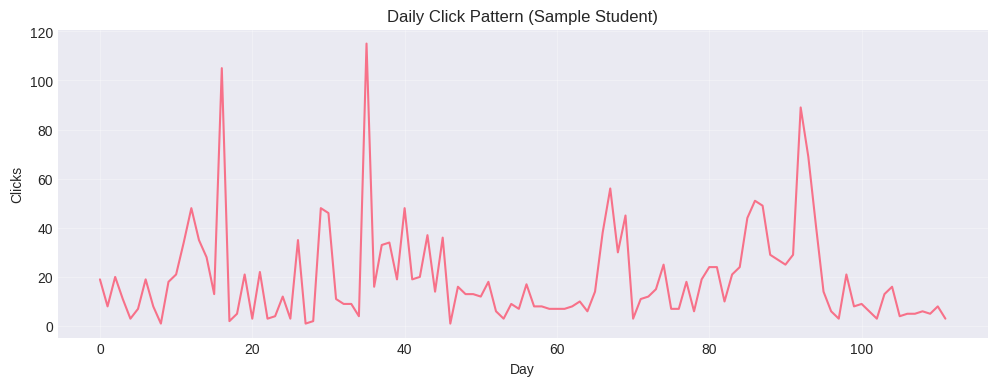

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(daily_clicks.values)
plt.title('Daily Click Pattern (Sample Student)')
plt.xlabel('Day')
plt.ylabel('Clicks')
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
adf_result = adfuller(daily_clicks.values)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print(f"Stationary: {adf_result[1] < 0.05}")

ADF Statistic: -3.0603
p-value: 0.0296
Stationary: True


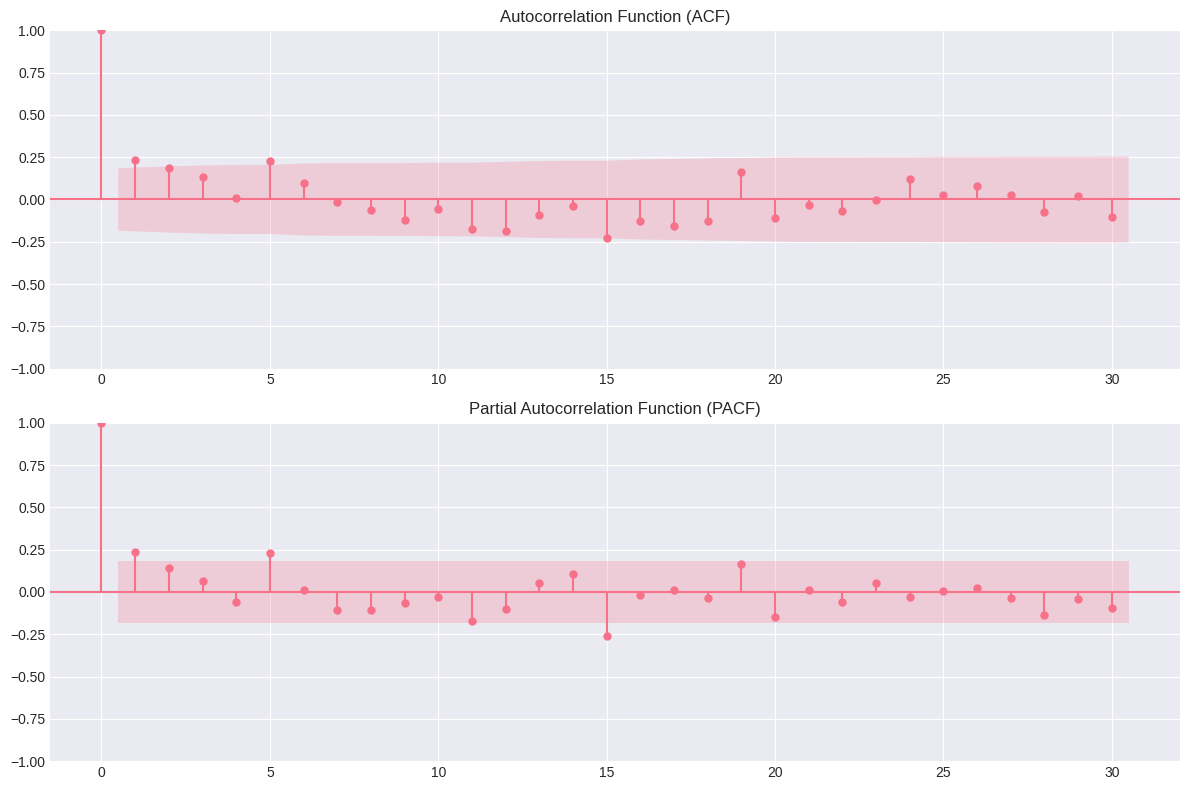

In [33]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(daily_clicks.values, lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(daily_clicks.values, lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Sequence Generation for LSTM

In [34]:
def create_sequences(vle_data, features_data, seq_len=30):
    sequences = []
    labels = []

    label_enc = LabelEncoder()
    features_data['risk_enc'] = label_enc.fit_transform(features_data['risk'])

    for idx, row in features_data.iterrows():
        if idx % 500 == 0:
            print(f"{idx}/{len(features_data)}")

        student_data = vle_data[
            (vle_data['id_student'] == row['id_student']) &
            (vle_data['code_module'] == row['code_module']) &
            (vle_data['code_presentation'] == row['code_presentation'])
        ]

        if len(student_data) < seq_len:
            continue

        daily = student_data.groupby('date')['sum_click'].sum().sort_index()

        for i in range(len(daily) - seq_len):
            seq = daily.iloc[i:i+seq_len].values
            seq_norm = seq / seq.max() if seq.max() > 0 else seq
            sequences.append(seq_norm.reshape(-1, 1))
            labels.append(row['risk_enc'])

    return np.array(sequences), np.array(labels), label_enc

In [35]:
print("Creating sequences...")
X_seq, y_labels, label_enc = create_sequences(vle_sample, features_clean, seq_len=30)

print(f"X shape: {X_seq.shape}")
print(f"y shape: {y_labels.shape}")
print(f"Classes: {label_enc.classes_}")

Creating sequences...
0/4049
500/4049
1000/4049
1500/4049
2000/4049
2500/4049
3000/4049
3500/4049
4000/4049
X shape: (169507, 30, 1)
y shape: (169507,)
Classes: ['High' 'Low' 'Medium']


## Train-Test Split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"Train: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

Train: 135605 samples
Test: 33902 samples


In [37]:
unique, counts = np.unique(y_train, return_counts=True)
for cls, cnt in zip(label_enc.classes_, counts):
    print(f"{cls}: {cnt} ({cnt/len(y_train)*100:.1f}%)")

High: 6586 (4.9%)
Low: 89917 (66.3%)
Medium: 39102 (28.8%)


## Bi-LSTM Model

In [38]:
def build_model(seq_len, n_features, n_classes):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=(seq_len, n_features)),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [39]:
model = build_model(
    seq_len=X_train.shape[1],
    n_features=X_train.shape[2],
    n_classes=len(np.unique(y_train))
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 30, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,027 (1.32 MB)

 Trainable params: 345,027 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

In [41]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6559 - loss: 0.7812

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 66s 17ms/step - accuracy: 0.6559 - loss: 0.7812 - val_accuracy: 0.6659 - val_loss: 0.7556
Epoch 2/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6613 - loss: 0.7647 - val_accuracy: 0.6659 - val_loss: 0.7545
Epoch 3/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6631 - loss: 0.7609 - val_accuracy: 0.6659 - val_loss: 0.7487
Epoch 4/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6618 - loss: 0.7569

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6618 - loss: 0.7569 - val_accuracy: 0.6666 - val_loss: 0.7460
Epoch 5/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6609 - loss: 0.7570 - val_accuracy: 0.6665 - val_loss: 0.7447
Epoch 6/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6617 - loss: 0.7538

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6617 - loss: 0.7538 - val_accuracy: 0.6679 - val_loss: 0.7383
Epoch 7/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6638 - loss: 0.7480

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6638 - loss: 0.7480 - val_accuracy: 0.6689 - val_loss: 0.7351
Epoch 8/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6631 - loss: 0.7418

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6631 - loss: 0.7418 - val_accuracy: 0.6704 - val_loss: 0.7240
Epoch 9/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6680 - loss: 0.7278

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6680 - loss: 0.7278 - val_accuracy: 0.6729 - val_loss: 0.7080
Epoch 10/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6719 - loss: 0.7129

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6719 - loss: 0.7129 - val_accuracy: 0.6837 - val_loss: 0.6877
Epoch 11/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6833 - loss: 0.6825

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.6833 - loss: 0.6825 - val_accuracy: 0.6985 - val_loss: 0.6553
Epoch 12/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7019 - loss: 0.6466

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.7019 - loss: 0.6466 - val_accuracy: 0.7245 - val_loss: 0.6092
Epoch 13/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7298 - loss: 0.6025

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step - accuracy: 0.7298 - loss: 0.6025 - val_accuracy: 0.7436 - val_loss: 0.5716
Epoch 14/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7529 - loss: 0.5554

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.7529 - loss: 0.5554 - val_accuracy: 0.7777 - val_loss: 0.5135
Epoch 15/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7782 - loss: 0.5068

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.7782 - loss: 0.5068 - val_accuracy: 0.8102 - val_loss: 0.4574
Epoch 16/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8064 - loss: 0.4531

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8064 - loss: 0.4531 - val_accuracy: 0.8371 - val_loss: 0.4043
Epoch 17/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8258 - loss: 0.4151

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8258 - loss: 0.4151 - val_accuracy: 0.8437 - val_loss: 0.3835
Epoch 18/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8451 - loss: 0.3785

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8451 - loss: 0.3785 - val_accuracy: 0.8624 - val_loss: 0.3539
Epoch 19/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8633 - loss: 0.3402

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8633 - loss: 0.3402 - val_accuracy: 0.8795 - val_loss: 0.3195
Epoch 20/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8784 - loss: 0.3114

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8784 - loss: 0.3114 - val_accuracy: 0.8926 - val_loss: 0.2847
Epoch 21/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8875 - loss: 0.2854

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8875 - loss: 0.2854 - val_accuracy: 0.9025 - val_loss: 0.2584
Epoch 22/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8998 - loss: 0.2618

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.8998 - loss: 0.2618 - val_accuracy: 0.9143 - val_loss: 0.2326
Epoch 23/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9051 - loss: 0.2440

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9051 - loss: 0.2440 - val_accuracy: 0.9235 - val_loss: 0.2153
Epoch 24/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9167 - loss: 0.2230

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9167 - loss: 0.2231 - val_accuracy: 0.9278 - val_loss: 0.1982
Epoch 25/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9212 - loss: 0.2103 - val_accuracy: 0.9266 - val_loss: 0.2080
Epoch 26/50
3388/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9216 - loss: 0.2102

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9216 - loss: 0.2102 - val_accuracy: 0.9337 - val_loss: 0.1859
Epoch 27/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9324 - loss: 0.1834

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9324 - loss: 0.1834 - val_accuracy: 0.9417 - val_loss: 0.1629
Epoch 28/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9377 - loss: 0.1695

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9377 - loss: 0.1695 - val_accuracy: 0.9468 - val_loss: 0.1533
Epoch 29/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9387 - loss: 0.1644

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9387 - loss: 0.1644 - val_accuracy: 0.9471 - val_loss: 0.1539
Epoch 30/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9416 - loss: 0.1574

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9416 - loss: 0.1574 - val_accuracy: 0.9546 - val_loss: 0.1361
Epoch 31/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9461 - loss: 0.1473

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9461 - loss: 0.1473 - val_accuracy: 0.9555 - val_loss: 0.1290
Epoch 32/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9477 - loss: 0.1440

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9477 - loss: 0.1440 - val_accuracy: 0.9594 - val_loss: 0.1209
Epoch 33/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9497 - loss: 0.1388 - val_accuracy: 0.9585 - val_loss: 0.1271
Epoch 34/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9517 - loss: 0.1341

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9517 - loss: 0.1341 - val_accuracy: 0.9624 - val_loss: 0.1137
Epoch 35/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9555 - loss: 0.1218

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9555 - loss: 0.1218 - val_accuracy: 0.9646 - val_loss: 0.1103
Epoch 36/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9563 - loss: 0.1192 - val_accuracy: 0.9597 - val_loss: 0.1190
Epoch 37/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9579 - loss: 0.1160 - val_accuracy: 0.9630 - val_loss: 0.1130
Epoch 38/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9605 - loss: 0.1105 - val_accuracy: 0.9621 - val_loss: 0.1114
Epoch 39/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9591 - loss: 0.1148

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9591 - loss: 0.1148 - val_accuracy: 0.9675 - val_loss: 0.1027
Epoch 40/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9635 - loss: 0.1027 - val_accuracy: 0.9666 - val_loss: 0.1049
Epoch 41/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9649 - loss: 0.0999

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9649 - loss: 0.0999 - val_accuracy: 0.9697 - val_loss: 0.0937
Epoch 42/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9656 - loss: 0.0982

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9656 - loss: 0.0982 - val_accuracy: 0.9701 - val_loss: 0.0916
Epoch 43/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9664 - loss: 0.0930 - val_accuracy: 0.9674 - val_loss: 0.1006
Epoch 44/50
3390/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9687 - loss: 0.0906

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9687 - loss: 0.0906 - val_accuracy: 0.9735 - val_loss: 0.0900
Epoch 45/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9669 - loss: 0.0914 - val_accuracy: 0.9707 - val_loss: 0.0947
Epoch 46/50
3391/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9685 - loss: 0.0877

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9685 - loss: 0.0877 - val_accuracy: 0.9735 - val_loss: 0.0818
Epoch 47/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9720 - loss: 0.0805

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9720 - loss: 0.0805 - val_accuracy: 0.9737 - val_loss: 0.0859
Epoch 48/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9709 - loss: 0.0816

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9709 - loss: 0.0816 - val_accuracy: 0.9763 - val_loss: 0.0797
Epoch 49/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9715 - loss: 0.0818

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9715 - loss: 0.0818 - val_accuracy: 0.9768 - val_loss: 0.0762
Epoch 50/50
3389/3391 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9730 - loss: 0.0779

3391/3391 ━━━━━━━━━━━━━━━━━━━━ 58s 17ms/step - accuracy: 0.9730 - loss: 0.0779 - val_accuracy: 0.9780 - val_loss: 0.0731


## Evaluation

In [42]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

Test Loss: 0.0671
Test Accuracy: 0.9798


In [43]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_enc.classes_))

1060/1060 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
              precision    recall  f1-score   support

        High       0.97      0.92      0.94      1647
         Low       0.98      0.99      0.99     22480
      Medium       0.98      0.97      0.97      9775

    accuracy                           0.98     33902
   macro avg       0.98      0.96      0.97     33902
weighted avg       0.98      0.98      0.98     33902



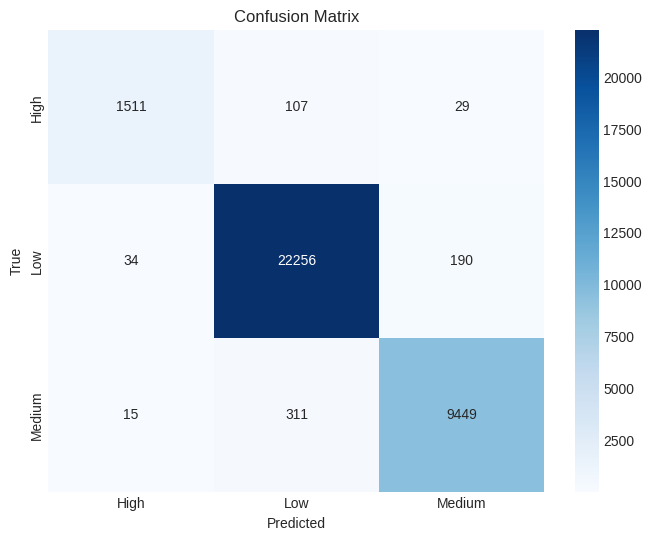

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=label_enc.classes_,
           yticklabels=label_enc.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

## Training History

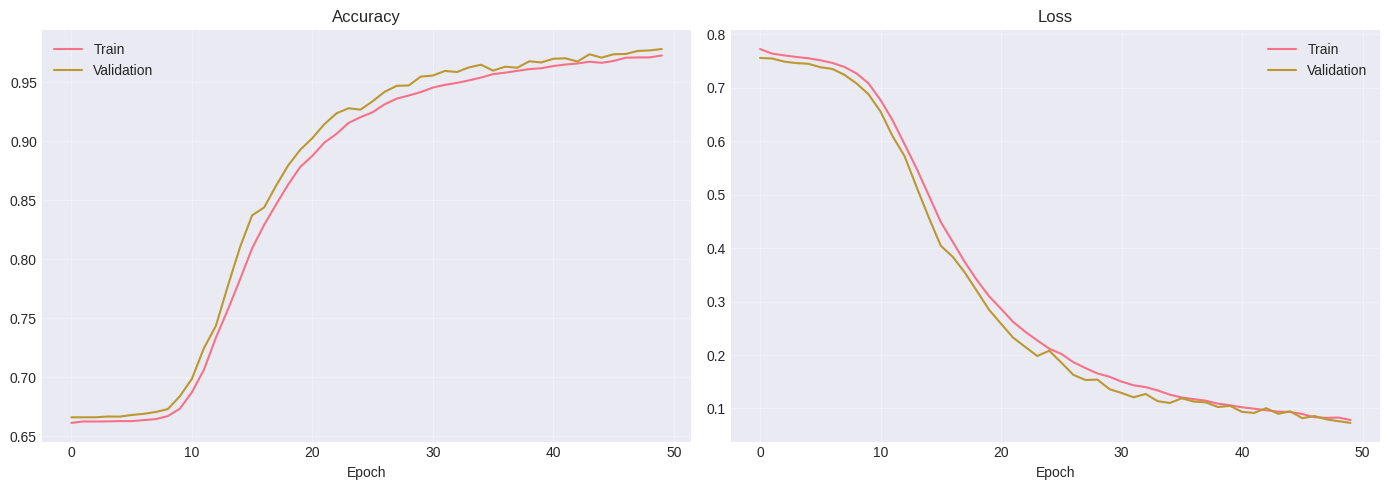

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Save Artifacts

In [46]:
model.save('procrastination_bilstm.h5')
print("Model saved")

Model saved


In [47]:
features_clean.to_csv('features_with_labels.csv', index=False)
print("Features saved")

Features saved


In [48]:
import pickle

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_enc, f)

print("Preprocessors saved")

Preprocessors saved


## Summary

Pre-trained model ready for transfer learning with local institutional data.